<a href="https://colab.research.google.com/github/basmala-kamal/tut-pricing-model/blob/main/body-splash-pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install requests beautifulsoup4


In [151]:
import requests
from bs4 import BeautifulSoup


In [177]:
import json
import pandas as pd
import re

# 1. Load the JSON file
with open("body+splash.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Convert to a pandas DataFrame for easier data manipulation
df = pd.DataFrame(data)
df = df.dropna(subset=["price", "rating"])
import time


# Define the function to scrape the brand name
def scrape_brand_name(session, url):
    try:
        if not url or not url.startswith("http"):  # Validate URL
            return None

        # Send a GET request to the URL using the session
        response = session.get(url, timeout=10)
        response.raise_for_status()  # Raise an error for HTTP issues

        # Parse the page content with BeautifulSoup
        soup = BeautifulSoup(response.content, "html.parser")

        # Adjust this selector based on the actual structure of the webpage
        brand_tag = soup.find("tr", class_="a-spacing-small po-brand")
        if brand_tag:
            td_tag = brand_tag.find("td", class_="a-span9")
            if td_tag:
                span_tag = td_tag.find("span", class_="a-size-base po-break-word")
                if span_tag:
                    return span_tag.get_text(strip=True)

        # Return None if the brand name is not found
        return None

    except requests.exceptions.RequestException as e:
        print(f"Network error scraping {url}: {e}")
        return None
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return None

# Load the JSON file

"""
# Ensure the 'link' column exists and is valid
if "link" in df.columns:
    # Create a requests session
    with requests.Session() as session:
        # Set a User-Agent header to mimic a browser (optional but recommended)
        session.headers.update({
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
        })

        # Apply the scraping function to the 'link' column
        brand_names = []
        for idx, url in enumerate(df["link"]):
            print(f"Scraping {idx + 1}/{len(df)}: {url}")
            brand_name = scrape_brand_name(session, url)
            brand_names.append(brand_name)

            # Throttle requests to avoid getting blocked
            time.sleep(2)

        # Add the scraped brand names to the DataFrame
        df["brand_name"] = brand_names"""


def clean_price(price_str):
    if price_str is None:
        return None
    numeric_str = re.sub(r"[^\d\.]", "", price_str)
    try:
        return float(numeric_str)
    except ValueError:
        return None

df["price_numeric"] = df["price"].apply(clean_price)


def clean_rating(rating_str):
    if rating_str is None:
        return None


    match = re.search(r"\d+(\.\d+)?", rating_str)
    if match:
        try:
            return float(match.group(0))
        except ValueError:
            return None
    return None


df["rating_numeric"] = df["rating"].apply(clean_rating)


def extract_volume(title_str):
    # Check for "أوز" (prioritize this if found)
    match_oz = re.search(r'(\d+(?:\.\d+)?)\s*(?:مل\.\s*أوز|أوز)', title_str)
    if match_oz:
        return float(match_oz.group(1)) * 29.5735  # Convert oz to ml

    # Check for "مل" (only if "أوز" is not found)
    match_ml = re.search(r'(\d+(?:\.\d+)?)\s*مل', title_str)
    if match_ml:
        return float(match_ml.group(1))

    # Check for "أونص", "أونصة", or "اونصة" and convert to ml
    match_ounce = re.search(r'(\d+(?:\.\d+)?)\s*(?:أونص|اونص|أونصة|اونصة)', title_str)
    if match_ounce:
        return float(match_ounce.group(1)) * 29.5 # Convert oz to ml

    # If no match, return None
    return None


# Apply the function to the DataFrame
df["volume"] = df["title"].apply(extract_volume)

def remove_duplicates_by_name_and_price(df):
    # Sort the DataFrame to keep the first occurrence of each duplicate
    df = df.sort_values(by=["title", "price_numeric"])

    # Drop duplicates based on 'name' and 'price_numeric'
    df = df.drop_duplicates(subset=["title", "price_numeric"], keep="first")

    return df

# Apply the duplicate removal function to the DataFrame
df = remove_duplicates_by_name_and_price(df)
# ------------------------------------------------------------------------------
# Final cleaned DataFrame
df = df[~df["title"].str.contains("عرق|التعرق|تعرق|العرق|لوشن|مرطب", na=False)]
print(df)


                                                 title         price  \
124  - بخاخ معطر برائحة الفانيليا والسكر الناعم من ...   ‏84.98 ريال   
257  How to Make Perfume at Home: DIY Scents for Pe...   ‏86.12 ريال   
300  ارماف بخاخ الجسم انشانتد رومانس للنساء 200 مل ...   ‏99.00 ريال   
194    ارماف بخاخ للجسم فلور للنساء من ميمنتو - 250 مل   ‏72.00 ريال   
278      ارماف دي لا مارك روج معطر للجسم للنساء 100 مل  ‏151.00 ريال   
..                                                 ...           ...   
72   ميكا ايلا رذاذ معطر للجسم بالفانيلا، للجنسين- ...   ‏31.00 ريال   
33   ميكا ايلا معطر الجسم لوست ان فانتاسي - 250 مل،...   ‏21.41 ريال   
255    ناوتيكا بخاخ الجسم فوياج 6 اونصة سائلة، للجنسين  ‏105.10 ريال   
53   يومار كوليكشن - بخاخ عطر جسم مايك ايفري ثينغ م...   ‏15.87 ريال   
55   يومار كوليكشن - بخاخ معطر للجسم لوف ويذ اوت لي...   ‏13.23 ريال   

            rating                                               link  \
124  4.1 من 5 نجوم  https://www.amazon.sa/%D9%81%D9%8A%D9%83%D

In [178]:
df

,title,price,rating,link,price_numeric,rating_numeric,volume
124,- بخاخ معطر برائحة الفانيليا والسكر الناعم من ...,‏84.98 ريال,4.1 من 5 نجوم,https://www.amazon.sa/%D9%81%D9%8A%D9%83%D8%AA...,84.98,4.1,100.0
257,How to Make Perfume at Home: DIY Scents for Pe...,‏86.12 ريال,4.3 من 5 نجوم,https://www.amazon.sa/%D9%84%D9%84%D8%AC%D8%B3...,86.12,4.3,NaN
300,ارماف بخاخ الجسم انشانتد رومانس للنساء 200 مل ...,‏99.00 ريال,3.9 من 5 نجوم,https://www.amazon.sa/%D9%84%D9%84%D8%AC%D8%B3...,99.00,3.9,200.0
194,ارماف بخاخ للجسم فلور للنساء من ميمنتو - 250 مل,‏72.00 ريال,3.8 من 5 نجوم,https://www.amazon.sa/%D8%B3%D8%A8%D9%84%D8%A7...,72.00,3.8,250.0
278,ارماف دي لا مارك روج معطر للجسم للنساء 100 مل,‏151.00 ريال,5.0 من 5 نجوم,https://www.amazon.sa/%D9%84%D9%84%D8%AC%D8%B3...,151.00,5.0,100.0
...,...,...,...,...,...,...,...
72,ميكا ايلا رذاذ معطر للجسم بالفانيلا، للجنسين- ...,‏31.00 ريال,3.4 من 5 نجوم,https://www.amazon.sa/%D8%A8%D8%AE%D8%A7%D8%AE...,31.00,3.4,250.0
33,ميكا ايلا معطر الجسم لوست ان فانتاسي - 250 مل،...,‏21.41 ريال,5.0 من 5 نجوم,https://www.amazon.sa/%D8%AC%D9%8A-%D9%83%D8%A...,21.41,5.0,250.0
255,ناوتيكا بخاخ الجسم فوياج 6 اونصة سائلة، للجنسين,‏105.10 ريال,4.5 من 5 نجوم,https://www.amazon.sa/%D9%84%D9%84%D8%AC%D8%B3...,105.10,4.5,177.0
53,يومار كوليكشن - بخاخ عطر جسم مايك ايفري ثينغ م...,‏15.87 ريال,3.5 من 5 نجوم,https://www.amazon.sa/%D8%A8%D8%AE%D8%A7%D8%AE...,15.87,3.5,200.0


In [179]:

def adjust_price_for_sets(df):
    def update_price(row):
        title = row["title"]

        # Case 1: Contains 'مجموعة' and 'قطع'
        if "مجموعة" in title and "قطع" in title:
            match = re.search(r'(\d+)\s*قطع', title)
            if match:
                num_items = int(match.group(1))
                if num_items > 0 and pd.notna(row["price_numeric"]):
                    return row["price_numeric"] / num_items

        # Case 2: Contains 'قطعتين' or 'زجاجتين'
        if re.search(r'(قطعتين|زجاجتين)', title):
            if pd.notna(row["price_numeric"]):
                return row["price_numeric"] / 2

        # If no adjustments, return the original price
        return row["price_numeric"]

    # Apply the function to the 'price_numeric' column
    df["price_numeric"] = df.apply(update_price, axis=1)
    return df

# Apply the function to your DataFrame
df = adjust_price_for_sets(df)

# Example: Verify with updated rows that match 'مجموعة', 'قطعتين', or 'زجاجتين'
print(df[df["title"].str.contains("مجموعة|قطعتين|زجاجتين")])


                                                 title         price  \
171  باث آند بودي وركس - بخاخات عطر جيد - عبوة من ز...  ‏229.00 ريال   
83   بخاخ معطر برائحة زهر الكرز الياباني 8 اونصة (م...  ‏144.00 ريال   
265  سبلاش الجسم كيوبيد هارت للنساء من ووتاجيرل| عط...   ‏80.00 ريال   
143  ليرير بخاخ الجسم رومانس من مجموعة كلاسيك من وت...   ‏63.46 ريال   
144  ليرير بخاخ معطر للجسم من مجموعة كلاسيك فانتازي...   ‏53.48 ريال   
253  ليرير سبلاش للجسم ماندرين تويست للنساء من ووتا...  ‏104.15 ريال   
258  ليرير سبلاش معطر للجسم سبيل باوند للنساء من وو...   ‏72.28 ريال   
254  ليرير سبلاش معطر للجسم من مجموعة رومانس كلاسيك...   ‏76.71 ريال   
260  ليرير مجموعة سبلاش للجسم للنساء من ووتاجيرل، ع...   ‏81.21 ريال   
77   مجموعة بخاخ ناتشورال بيوتي من فيكتوريا سيكريت ...  ‏101.96 ريال   
85   مجموعة سبلاش للجسم ووت اجيرل للنساء من 3 قطع، ...  ‏100.90 ريال   
76   مجموعة كومبو سبلاش للجسم من لاير، 25 مل (عبوة ...   ‏57.18 ريال   
129  مجموعة ناتشورال بيوتي ميست من فيكتوريا سيكريت ...  ‏150.00 

In [180]:
zero_or_negative = df[df["volume"] <= 50]
zero_or_negative

,title,price,rating,link,price_numeric,rating_numeric,volume
237,اريانا جراندي عطر كلاود او دي بارفان للنساء، 1...,‏310.00 ريال,4.6 من 5 نجوم,https://www.amazon.sa/%D8%B3%D8%A8%D9%84%D8%A7...,310.000,4.6,29.5
267,بانيير دي سين روز أو دي تواليت - صنع في فرنسا ...,‏283.00 ريال,4.1 من 5 نجوم,https://www.amazon.sa/%D9%84%D9%84%D8%AC%D8%B3...,283.000,4.1,50.0
273,دولتشي اند غابانا ذا ون للنساء 30 مل - او دى ب...,‏245.00 ريال,4.5 من 5 نجوم,https://www.amazon.sa/%D9%84%D9%84%D8%AC%D8%B3...,245.000,4.5,30.0
281,عطر روز اوريجينال رول اون بدون كحول 9 مل، للجنسين,‏69.81 ريال,4.1 من 5 نجوم,https://www.amazon.sa/%D9%84%D9%84%D8%AC%D8%B3...,69.810,4.1,9.0
76,مجموعة كومبو سبلاش للجسم من لاير، 25 مل (عبوة ...,‏57.18 ريال,4.0 من 5 نجوم,https://www.amazon.sa/%D8%A8%D8%AE%D8%A7%D8%AE...,14.295,4.0,25.0


In [ ]:
"""# Define the title to search for
title_to_search = "كولور مي بيرل، للنساء، 5.7 أونصة سائلة"


# Find the row where the title matches
matching_row = df[df["title"] == title_to_search]

# Display the matching row
if not matching_row.empty:
    print(matching_row)
else:
    print("No matching item found.")"""


'# Define the title to search for\ntitle_to_search = "كولور مي بيرل، للنساء، 5.7 أونصة سائلة"\n\n\n# Find the row where the title matches\nmatching_row = df[df["title"] == title_to_search]\n\n# Display the matching row\nif not matching_row.empty:\n    print(matching_row)\nelse:\n    print("No matching item found.")'

In [181]:
df_cleaned = (
    df[["title", "price_numeric", "rating_numeric", "volume"]]
    .dropna(subset=["title", "price_numeric", "rating_numeric","volume"])
)

df_cleaned.shape


(158, 4)

<Axes: xlabel='volume', ylabel='price_numeric'>

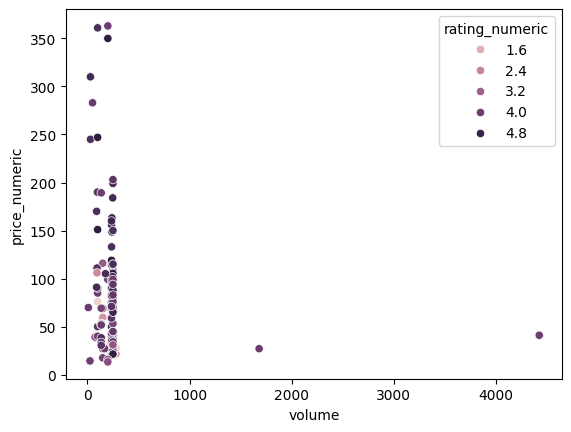

In [182]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data = df_cleaned, x = 'volume', y = 'price_numeric', hue = 'rating_numeric')

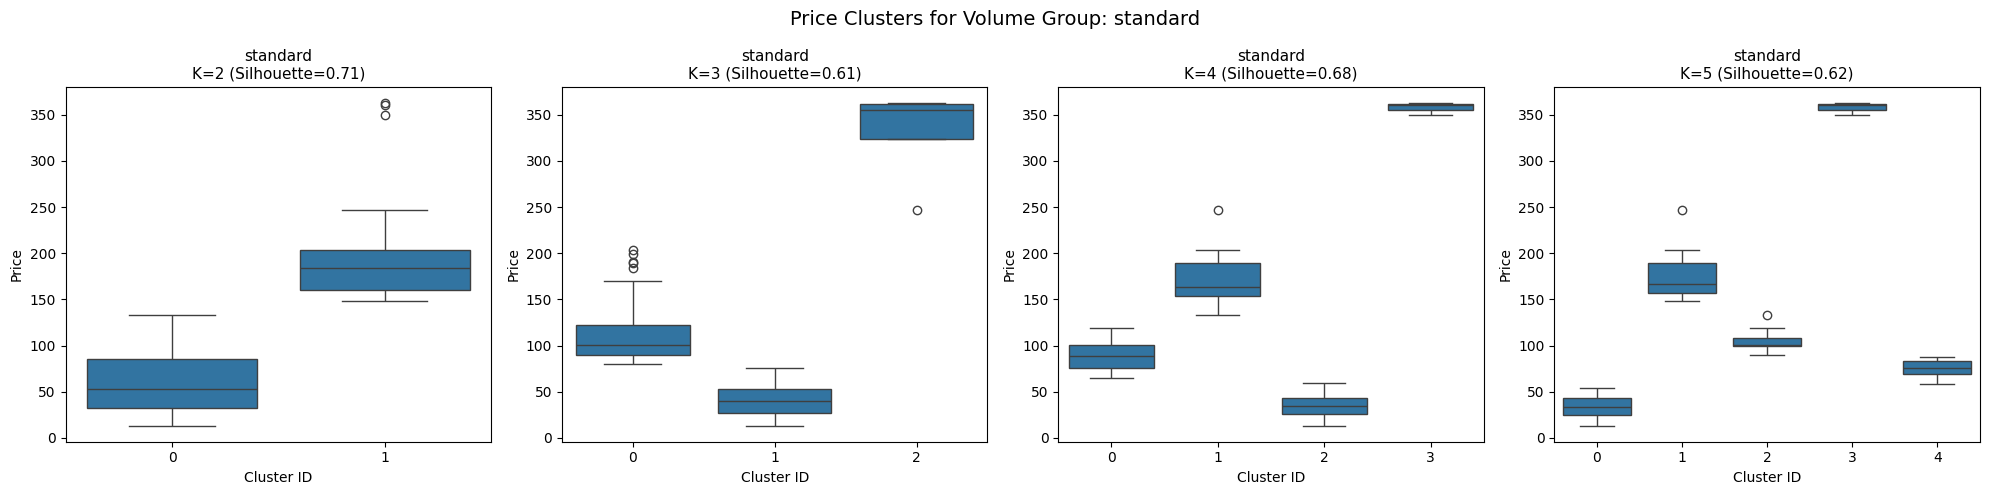

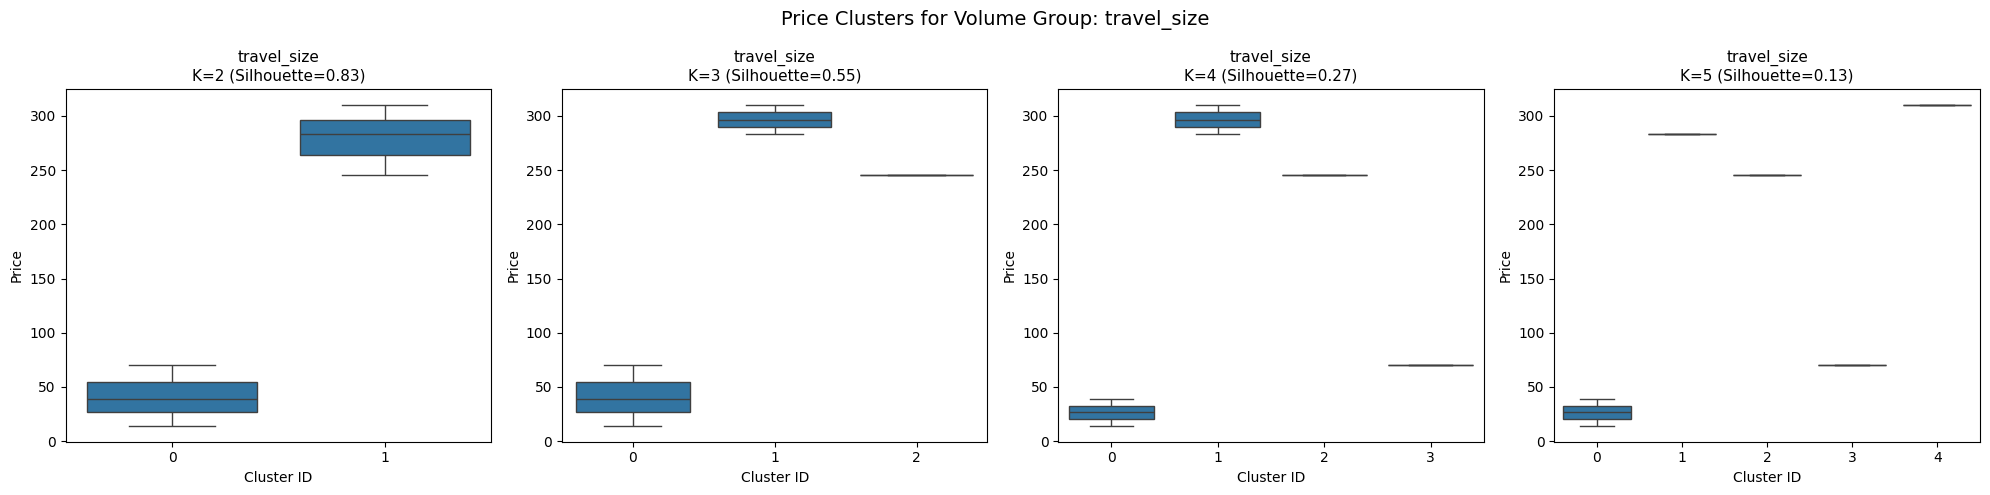

No data for group 'nan'. Skipping.


In [183]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure no NaNs in required columns
df_cleaned = df_cleaned.dropna(subset=["volume", "price_numeric"])

# 1) Create volume groups
df_cleaned["volume_group"] = pd.cut(
    df_cleaned["volume"],
    bins=[0, 75, 250],
    labels=["travel_size", "standard"],
    include_lowest=True  # Include 0 in the first group
)

for group_name in df_cleaned["volume_group"].unique():
    subset = df_cleaned[df_cleaned["volume_group"] == group_name].copy()

    if subset.empty:
        print(f"No data for group '{group_name}'. Skipping.")
        continue

    # 2) Scale ONLY price_numeric
    if len(subset) <= 1:
        print(f"Only one row in group '{group_name}'. Skipping clustering.")
        continue

    X_price = subset[["price_numeric"]].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_price)

    # Make a figure with 4 subplots
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

    for idx, k in enumerate([2,3,4,5]):
        if len(subset) < k:
            print(f"Skipping k={k} for group '{group_name}' due to insufficient data.")
            continue

        kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
        kmeans.fit(X_scaled)

        # Store cluster labels
        cluster_col = f"cluster_k{k}"
        subset[cluster_col] = kmeans.labels_

        # Silhouette score (handle cases with < 2 clusters)
        if len(subset[cluster_col].unique()) > 1:
            sil_score = silhouette_score(X_scaled, kmeans.labels_)
        else:
            sil_score = np.nan

        # 3) Visualize via boxplot
        sns.boxplot(
            x=cluster_col,
            y="price_numeric",
            data=subset,
            ax=axes[idx]
        )
        axes[idx].set_title(
            f"{group_name}\nK={k} (Silhouette={sil_score:.2f})",
            fontsize=11
        )
        axes[idx].set_xlabel("Cluster ID")
        axes[idx].set_ylabel("Price")

    # Save cluster labels back to df_cleaned
    for cluster_col in [f"cluster_k{k}" for k in [2,3,4,5]]:
        df_cleaned.loc[subset.index, cluster_col] = subset[cluster_col]

    plt.suptitle(f"Price Clusters for Volume Group: {group_name}", fontsize=14)
    plt.subplots_adjust(top=0.85)
    plt.tight_layout()
    plt.show()


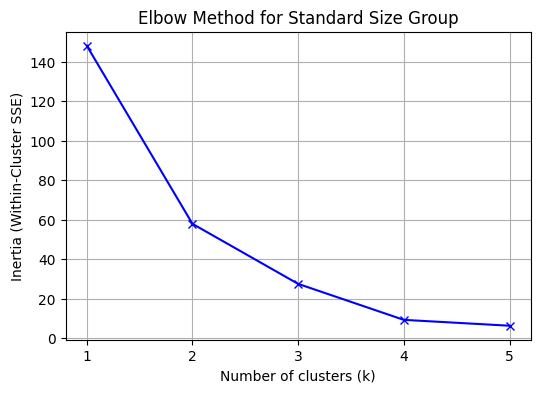

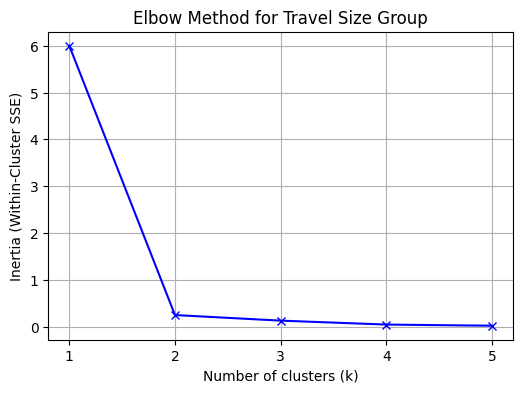

In [184]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Process for 'standard' size group
standard_group = df_cleaned[df_cleaned["volume_group"] == "standard"]
if standard_group.empty:
    print("No data for 'standard' size group. Skipping.")
else:
    # Extract price column for clustering
    X_price_standard = standard_group[["price_numeric"]].values

    # Skip clustering if there's only one row
    if len(standard_group) <= 1:
        print("Only one row in 'standard' size group. Skipping clustering.")
    else:
        # Scale prices for standard group
        scaler = StandardScaler()
        X_scaled_standard = scaler.fit_transform(X_price_standard)

        # Elbow method for the standard group
        distortions_standard = []
        K_range = range(1, 6)  # Try k = 1 to 5
        for k in K_range:
            kmeans_temp_standard = KMeans(n_clusters=k, random_state=0, n_init=10)
            kmeans_temp_standard.fit(X_scaled_standard)
            distortions_standard.append(kmeans_temp_standard.inertia_)

        # Plot Elbow Method for standard group
        plt.figure(figsize=(6, 4))
        plt.plot(K_range, distortions_standard, 'bx-')
        plt.title('Elbow Method for Standard Size Group')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Inertia (Within-Cluster SSE)')
        plt.xticks(K_range)  # Show integer ticks
        plt.grid(True)
        plt.show()

# Process for 'travel_size' group
travel_group = df_cleaned[df_cleaned["volume_group"] == "travel_size"]
if travel_group.empty:
    print("No data for 'travel_size' group. Skipping.")
else:
    # Extract price column for clustering
    X_price_travel = travel_group[["price_numeric"]].values

    # Skip clustering if there's only one row
    if len(travel_group) <= 1:
        print("Only one row in 'travel_size' group. Skipping clustering.")
    else:
        # Scale prices for travel group
        scaler = StandardScaler()
        X_scaled_travel = scaler.fit_transform(X_price_travel)

        # Elbow method for the travel group
        distortions_travel = []
        K_range = range(1, 6)  # Try k = 1 to 5
        for k in K_range:
            kmeans_temp_travel = KMeans(n_clusters=k, random_state=0, n_init=10)
            kmeans_temp_travel.fit(X_scaled_travel)
            distortions_travel.append(kmeans_temp_travel.inertia_)

        # Plot Elbow Method for travel group
        plt.figure(figsize=(6, 4))
        plt.plot(K_range, distortions_travel, 'bx-')
        plt.title('Elbow Method for Travel Size Group')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Inertia (Within-Cluster SSE)')
        plt.xticks(K_range)  # Show integer ticks
        plt.grid(True)
        plt.show()


In [190]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1) Make two volume bins
df_cleaned["volume_group"] = pd.cut(
    df_cleaned["volume"],
    bins=[0, 75, 250],
    labels=["travel_size", "standard"]
)

all_dfs = []

for group_name in ["travel_size", "standard"]:
    # 2) Subset data for that group and scale prices
    subset = df_cleaned[df_cleaned["volume_group"] == group_name].copy()
    X_price = subset[["price_numeric"]].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_price)

    # 3) Pick k=4 if high_volume, else k=6 if low_volume
    if group_name == "standard":
        k = 4
    else:
        k = 2

    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
    kmeans.fit(X_scaled)

    # Store cluster labels in the subset
    subset["final_cluster"] = kmeans.labels_

    # Collect for concatenation later
    all_dfs.append(subset)

# 4) Combine back into one DataFrame
df_final = pd.concat(all_dfs, ignore_index=True)

# 5) Inspect cluster means, counts, etc.
summary = (
    df_final
    .groupby(["volume_group", "final_cluster"])["price_numeric"]
    .agg(["count", "mean", "min", "max"])
)
print(summary)


                            count        mean      min     max
volume_group final_cluster                                    
travel_size  0                  3   41.035000   14.295   69.81
             1                  3  279.333333  245.000  310.00
             2                  0         NaN      NaN     NaN
             3                  0         NaN      NaN     NaN
standard     0                 58   89.542759   65.000  119.00
             1                 15  173.599333  133.000  247.00
             2                 72   35.607917   13.230   59.51
             3                  3  358.000000  350.000  363.00


<ipython-input-190-60fe68a533d5>:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["volume_group", "final_cluster"])["price_numeric"]


In [191]:

summary["price_range"] = summary["max"] - summary["min"]

# Sort the summary by price_range in descending order
sorted_summary = summary.sort_values(by="price_range", ascending=False)

# Display the sorted summary
print(sorted_summary)


                            count        mean      min     max  price_range
volume_group final_cluster                                                 
standard     1                 15  173.599333  133.000  247.00      114.000
travel_size  1                  3  279.333333  245.000  310.00       65.000
             0                  3   41.035000   14.295   69.81       55.515
standard     0                 58   89.542759   65.000  119.00       54.000
             2                 72   35.607917   13.230   59.51       46.280
             3                  3  358.000000  350.000  363.00       13.000
travel_size  2                  0         NaN      NaN     NaN          NaN
             3                  0         NaN      NaN     NaN          NaN


In [192]:
# Sort by mean price (ascending) within each volume group
sorted_summary = summary.sort_values(by=["volume_group", "mean"], ascending=[True, True])

# Display the sorted summary
print(sorted_summary)


                            count        mean      min     max  price_range
volume_group final_cluster                                                 
travel_size  0                  3   41.035000   14.295   69.81       55.515
             1                  3  279.333333  245.000  310.00       65.000
             2                  0         NaN      NaN     NaN          NaN
             3                  0         NaN      NaN     NaN          NaN
standard     2                 72   35.607917   13.230   59.51       46.280
             0                 58   89.542759   65.000  119.00       54.000
             1                 15  173.599333  133.000  247.00      114.000
             3                  3  358.000000  350.000  363.00       13.000


High-end, low on trend

In [186]:
# Items in high_volume only
#df_high = df_final[df_final["volume_group"] == "high_volume"]

# Items in cluster 0 within low_volume
travel_highend = df_final[
    (df_final["volume_group"] == "travel_size") &
    (df_final["final_cluster"] == 1)
]

price_std = travel_highend["price_numeric"].std()
print(price_std)
travel_highend


32.65475973473596


,title,price_numeric,rating_numeric,volume,volume_group,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
0,اريانا جراندي عطر كلاود او دي بارفان للنساء، 1...,310.0,4.6,29.5,travel_size,1.0,1.0,1.0,4.0,1
1,بانيير دي سين روز أو دي تواليت - صنع في فرنسا ...,283.0,4.1,50.0,travel_size,1.0,1.0,1.0,1.0,1
2,دولتشي اند غابانا ذا ون للنساء 30 مل - او دى ب...,245.0,4.5,30.0,travel_size,1.0,2.0,2.0,2.0,1


Travel size bundled low price

In [187]:
travel_medium = df_final[
    (df_final["volume_group"] == "travel_size") &
    (df_final["final_cluster"] == 0)
]
titles_to_remove = [
    "مجموعة كومبو سبلاش للجسم من لاير، 25 مل (عبوة من 4 قطع)، للنساء",
    "ليرير مجموعة سبلاش للجسم من ووتاجيرل، عبوة من 5 قطع (60 مل) - ماندرين تويست، الفاوانيا الفرنسية، سيكريت كراش، امبر كيس، سبيل باوند، للنساء",
    ]
travel_bundle_lowprice = travel_medium[travel_medium["title"].isin(titles_to_remove)]
travel_bundle_lowprice



,title,price_numeric,rating_numeric,volume,volume_group,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
5,مجموعة كومبو سبلاش للجسم من لاير، 25 مل (عبوة ...,14.295,4.0,25.0,travel_size,0.0,0.0,0.0,0.0,0


travel size medium price, but very low **volume**

In [188]:
travel_medium = travel_medium[travel_medium["title"] != title_to_remove]

travel_medium

,title,price_numeric,rating_numeric,volume,volume_group,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
3,رذاذ عطري ناعم بحجم مناسب للسفر من جابانيز تشي...,39.00,3.5,75.0,travel_size,0.0,0.0,0.0,0.0,0
4,عطر روز اوريجينال رول اون بدون كحول 9 مل، للجنسين,69.81,4.1,9.0,travel_size,0.0,0.0,3.0,3.0,0


 brazilian, english, imported products - low trend

In [194]:
standard_highend = df_final[
    (df_final["volume_group"] == "standard") &
    (df_final["final_cluster"] == 3)
]
price_std = standard_highend["price_numeric"].std()
print(price_std)
standard_highend

7.0


,title,price_numeric,rating_numeric,volume,volume_group,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
13,اوه بوتكاريو بخاخ للجسم سبا بلام من ناتيفا، 20...,350.0,5.0,200.0,standard,1.0,2.0,3.0,3.0,3
49,بخاخ معطر للجسم بجوز الهند من ذا بودي شوب، 100...,361.0,4.5,100.0,standard,1.0,2.0,3.0,3.0,3
98,عطر للنساء م للجسم من او بوتيكاريو Nسبا – كينو...,363.0,4.0,200.0,standard,1.0,2.0,3.0,3.0,3


middle range, all imported

In [197]:
standard_middle = df_final[
    (df_final["volume_group"] == "standard") &
    (df_final["final_cluster"] == 0)
]
price_std = standard_middle["price_numeric"].std()
print(price_std)
standard_middle


14.878993527683727


,title,price_numeric,rating_numeric,volume,volume_group,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
6,- بخاخ معطر برائحة الفانيليا والسكر الناعم من ...,84.98,4.1,100.0,standard,0.0,0.0,0.0,4.0,0
7,ارماف بخاخ الجسم انشانتد رومانس للنساء 200 مل ...,99.00,3.9,200.0,standard,0.0,0.0,0.0,2.0,0
8,ارماف بخاخ للجسم فلور للنساء من ميمنتو - 250 مل,72.00,3.8,250.0,standard,0.0,1.0,0.0,4.0,0
10,ارماف سبلاش الجسم اومو للنساء من ايطاليانو - 2...,109.00,2.6,250.0,standard,0.0,0.0,0.0,2.0,0
11,ارماف سبلاش الجسم جولد للنساء من ديلا ماركي - ...,83.00,5.0,250.0,standard,0.0,0.0,0.0,4.0,0
12,اوربو فري ستايلر سينتور معطر للجسم للنساء - 15...,116.00,3.3,150.0,standard,0.0,0.0,0.0,2.0,0
14,اينتو ذا نايت دايموند شيمر ميست 8 اونصة.، للنساء,85.00,4.7,236.0,standard,0.0,0.0,0.0,4.0,0
15,باث آند بودي وركس - بخاخات عطر جيد - عبوة من ز...,114.50,4.6,236.0,standard,0.0,0.0,0.0,2.0,0
16,باث اند بودي وركس آت ذا بيتش فاين فراجرانس ميس...,69.19,5.0,236.0,standard,0.0,1.0,0.0,4.0,0
18,باث اند بودي وركس بخاخ معطر فاخر من جينجهام، 2...,91.00,4.2,236.0,standard,0.0,0.0,0.0,2.0,0


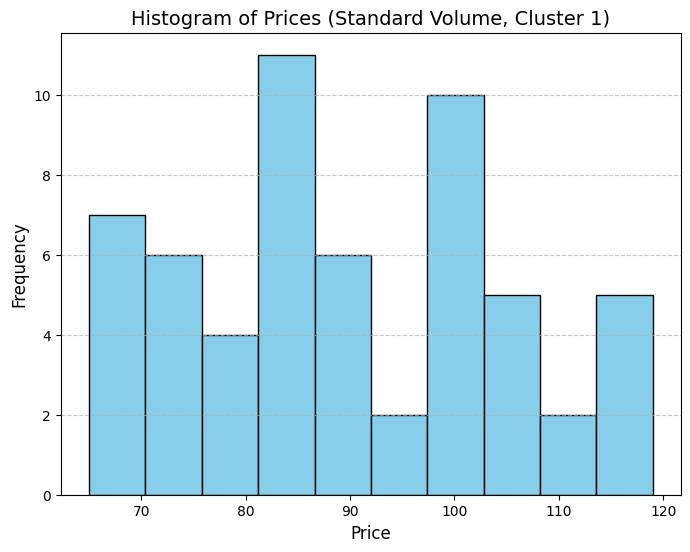

In [198]:
plt.figure(figsize=(8, 6))
plt.hist(standard_middle["price_numeric"], bins=10, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel("Price", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Histogram of Prices (Standard Volume, Cluster 1)", fontsize=14)

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

very low range, mostly privately labeled asian made

In [200]:
standard_low = df_final[
    (df_final["volume_group"] == "standard") &
    (df_final["final_cluster"] == 2)
]
price_std = standard_low["price_numeric"].std()
print(price_std)
standard_low

11.537312418256828


,title,price_numeric,rating_numeric,volume,volume_group,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
22,بادي فانتازيز - بخاخ للجسم من بودي فانتاسيز لل...,39.95,4.5,236.0,standard,0.0,1.0,2.0,0.0,2
25,بخاخ المسك الابيض المنعش للجسم من بدي فانتاسيز...,32.75,4.0,236.0,standard,0.0,1.0,2.0,0.0,2
26,بخاخ جسم برائحة سويت صن من بودي فانتازياز سيجن...,39.95,4.5,236.0,standard,0.0,1.0,2.0,0.0,2
27,بخاخ جسم ثاوزاند ويشز من باث اند بدي وركس، 236...,49.90,4.6,236.0,standard,0.0,1.0,2.0,0.0,2
28,بخاخ جسم فلامينجو 188 من يومسيرا، 250 مل، للجنسين,27.60,4.0,250.0,standard,0.0,1.0,2.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...
148,ميكا ايلا رذاذ معطر الجسم بالفراولة والشمبانيا...,21.41,3.4,250.0,standard,0.0,1.0,2.0,0.0,2
149,ميكا ايلا رذاذ معطر للجسم بالفانيلا، للجنسين- ...,31.00,3.4,250.0,standard,0.0,1.0,2.0,0.0,2
150,ميكا ايلا معطر الجسم لوست ان فانتاسي - 250 مل،...,21.41,5.0,250.0,standard,0.0,1.0,2.0,0.0,2
152,يومار كوليكشن - بخاخ عطر جسم مايك ايفري ثينغ م...,15.87,3.5,200.0,standard,0.0,1.0,2.0,0.0,2


mostly the same imported brands but the actually imported

In [204]:
standard_highmid = df_final[
    (df_final["volume_group"] == "standard") &
    (df_final["final_cluster"] == 1)
]
price_std = standard_highmid["price_numeric"].std()
print(price_std)
standard_highmid

28.86494821124915


,title,price_numeric,rating_numeric,volume,volume_group,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
9,ارماف دي لا مارك روج معطر للجسم للنساء 100 مل,151.00,5.0,100.00000,standard,1.0,0.0,1.0,1.0,1
17,باث اند بودي وركس بخاخ معطر فاخر للنساء من جاب...,160.00,4.0,236.00000,standard,1.0,0.0,1.0,1.0,1
23,بادي كولوجي ميست معطر للخيار والبطيخ من بادي ك...,133.00,4.5,236.56000,standard,0.0,0.0,1.0,2.0,1
71,ذا بدي شوب بخاخ للجسم برائحة الفراولة، للنساء،...,247.00,5.0,100.00000,standard,1.0,2.0,1.0,1.0,1
72,رذاذ الجسم فيكتوريا سيكريت كوكونت ميلك اند روز...,199.00,4.6,250.00000,standard,1.0,0.0,1.0,1.0,1
75,رذاذ معطر للجسم كراش من سول دي جينيرو، 240 مل،...,163.22,4.7,240.00000,standard,1.0,0.0,1.0,1.0,1
86,سول دي جانيرو شيروسا 59 عطر ميست 90 مل، خشب ال...,170.00,4.5,90.00000,standard,1.0,0.0,1.0,1.0,1
88,عطر باث اند بودي وركس تاهيتي آيلاند دريم فاين ...,156.00,4.6,236.00000,standard,1.0,0.0,1.0,1.0,1
93,عطر للجنسين ذا بودي شوب ساتسوما بودي ميست بخاخ...,190.00,4.3,97.59255,standard,1.0,0.0,1.0,1.0,1
104,فكتوريا سيكريت بخاخ الجسم بينك فريش اند كلين (...,203.00,4.3,250.00000,standard,1.0,0.0,1.0,1.0,1


Recommended B2C Price: 35.607917 RAS

>

Recommended B2B Price: 17.8RAS, assuming a retailer's margin of 50%
